In [ ]:
class Args:
    pass
filepath = "./args/CLIP.pkl"
import pickle
with open(filepath,"rb") as file:
    args = pickle.load(file)

In [2]:
import pandas as pd
import numpy as np
import torch
import my_token as T
import matplotlib.pyplot as plt
def read_model(filename):
    import torch
    model = args.model(args)
    #display(torch.load(filename).keys())
    model.load_state_dict( torch.load(filename))
    model.eval()
    return model


In [3]:
def build_dataset(filename,n=1000):
    import pandas as pd
    import my_token as T
    df = pd.read_csv(filename)[:n]
    dataset = args.dataset(df = df,maxlen = args.maxlen , vocab_size = args.vocab)
    return dataset

In [4]:
from my_token import ArithmeticDataset
import pandas as pd
dataset = ArithmeticDataset(df = pd.read_csv("./data/train.csv"),maxlen = 100 , vocab_size = 64)
from my_token import to_sentence
x,y = dataset[0]
print(to_sentence(x))
print(to_sentence(y))

<2*9: =7>                                                                                           
     =7>                                                                                            


In [5]:
"""dataset = build_dataset("./data/len7.csv")
import random
idx = random.randint( 0,len(dataset)-1 )
x , y , pe = dataset[idx]
x = x[None , :]
from my_token import to_sentence
print("equals:" , dataset.equals[idx])
print("x :" , to_sentence(x[0]))
print("y :" , to_sentence(y))
print("pe:" , to_sentence(pe))"""

'dataset = build_dataset("./data/len7.csv")\nimport random\nidx = random.randint( 0,len(dataset)-1 )\nx , y , pe = dataset[idx]\nx = x[None , :]\nfrom my_token import to_sentence\nprint("equals:" , dataset.equals[idx])\nprint("x :" , to_sentence(x[0]))\nprint("y :" , to_sentence(y))\nprint("pe:" , to_sentence(pe))'

In [6]:
"""args.re_time += 3
def eval_reGPT(model,dataset,batch_size=args.batch_size,mask = None):
    model = model.cuda()
    model.eval()
    import torch
    from tqdm import tqdm
    import my_token as T
    from my_token import to_sentence
    from torch.utils.data.dataloader import DataLoader
    loader = DataLoader(dataset , batch_size,num_workers=0,drop_last=False,shuffle=True)
    pbar = tqdm(loader)
    true_cnt = 0
    cnt = 0
    import numpy as np
    correct = np.zeros(args.re_times)
    with torch.no_grad():
        for _,(x,y) in enumerate(pbar):
            x, y  = x.cuda(), y.long().cuda() 
            mask = y==0
            logits_list = model(x,mask) 
            pred_list = [ torch.argmax( logits ,dim = -1) for logits in logits_list ]
            for pred in pred_list:
                pred[ y==0 ] = 0
            for i in range(args.re_times):
                correct[i] += torch.sum((pred_list[i] == y).to("cpu").all(1))
    return correct / len(dataset)
model = read_model("./model/reGPT.pt")
for i in range(10,21):
    dataset = build_dataset(f"./data/test/len{i}.csv",n=2000)
    test_acc = eval_reGPT(model=model,dataset=dataset,batch_size=args.batch_size)
    plt.plot(range(len(test_acc)),test_acc,label = f"len{i}")"""

'args.re_time += 3\ndef eval_reGPT(model,dataset,batch_size=args.batch_size,mask = None):\n    model = model.cuda()\n    model.eval()\n    import torch\n    from tqdm import tqdm\n    import my_token as T\n    from my_token import to_sentence\n    from torch.utils.data.dataloader import DataLoader\n    loader = DataLoader(dataset , batch_size,num_workers=0,drop_last=False,shuffle=True)\n    pbar = tqdm(loader)\n    true_cnt = 0\n    cnt = 0\n    import numpy as np\n    correct = np.zeros(args.re_times)\n    with torch.no_grad():\n        for _,(x,y) in enumerate(pbar):\n            x, y  = x.cuda(), y.long().cuda() \n            mask = y==0\n            logits_list = model(x,mask) \n            pred_list = [ torch.argmax( logits ,dim = -1) for logits in logits_list ]\n            for pred in pred_list:\n                pred[ y==0 ] = 0\n            for i in range(args.re_times):\n                correct[i] += torch.sum((pred_list[i] == y).to("cpu").all(1))\n    return correct / len(dat

In [7]:
def eval(model,dataset,batch_size=args.batch_size,mask = None):
    model = model.cuda()
    model.eval()
    import torch
    from tqdm import tqdm
    import my_token as T
    from my_token import to_sentence
    from torch.utils.data.dataloader import DataLoader
    loader = DataLoader(dataset , batch_size,num_workers=0,drop_last=False,shuffle=True)
    pbar = tqdm(loader)
    true_cnt = 0
    cnt = 0
    import numpy as np
    lst = []
    c_t = 0
    global acc
    with torch.no_grad():
        for _,(x,y) in enumerate(pbar):
            x, y  = x.cuda(), y.long().cuda() 
            pred = torch.argmax( model(x) ,dim = -1)
            pred[ y==0 ] = 0
            c_t += torch.sum((pred == y).to("cpu").all(1))
            true_cnt += torch.sum((pred == y) & (y != 0)).item()
            cnt += torch.sum(y != 0  ).item()
    #print("full match",int(c_t))
    global all_acc
    all_acc = int(c_t) / len(dataset)
    # 计算并打印准确率
    if cnt!=0:
        accuracy = true_cnt / cnt
        acc = accuracy
        #print(f'Accuracy: {accuracy * 100:.2f}%')
    return all_acc

In [8]:

import copy

def show(model,dataset):
    import random
    idx = random.randint( 0,len(dataset)-1 )
    model = model.cpu()
    x , y   = dataset[idx]
    x = x[None , :]
    logits = model(x)[0]
    pred = torch.argmax( logits ,dim = -1)
    from my_token import to_sentence
    pred[y==0] = 0
    print(str((y==pred).all(0).item()))
    print("x : " , to_sentence(x[0]))
    print("y :" , to_sentence(y))
    print("pr:",to_sentence(pred))
    print("w :","".join([ " " if b else "w"  for b in (y==pred).tolist()]))
    

In [9]:
def eval_epoch(filename):
    dataset = build_dataset(filename,n=2000)
    li = []
    for filename in args.output_list: 
        model = read_model(filename)
        li.append( eval(model=model,dataset=dataset,batch_size=args.batch_size))
    return li

In [10]:
"""
args.batch_size = 100
train_acc = eval_epoch(args.file_path)
plt.plot( range(len(train_acc)) ,train_acc ,label = "test" )
for i in range(5,9):
    test_acc = eval_epoch( f"./data/test/len{i}.csv")
    plt.plot(range(len(test_acc)),test_acc,label = f"len{i}")

plt.title(args.name)
plt.legend()
plt.show()    """

'\nargs.batch_size = 100\ntrain_acc = eval_epoch(args.file_path)\nplt.plot( range(len(train_acc)) ,train_acc ,label = "test" )\nfor i in range(5,9):\n    test_acc = eval_epoch( f"./data/test/len{i}.csv")\n    plt.plot(range(len(test_acc)),test_acc,label = f"len{i}")\n\nplt.title(args.name)\nplt.legend()\nplt.show()    '

100%|██████████| 10/10 [00:00<00:00, 21.69it/s]


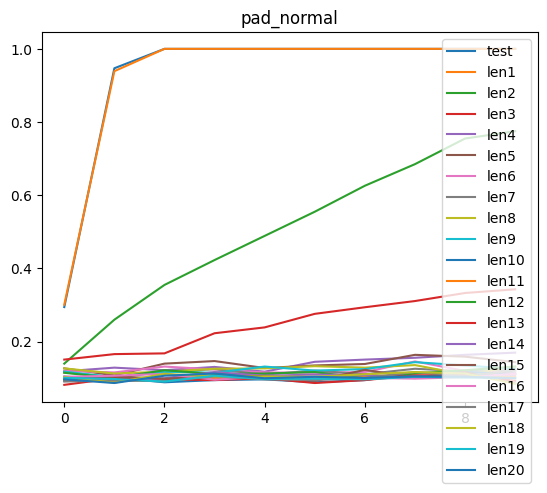

In [11]:

args.batch_size = 100
train_acc = eval_epoch(args.file_path)
plt.plot( range(len(train_acc)) ,train_acc ,label = "test" )
for i in range(1,21):
    test_acc = eval_epoch( f"./data/test/len{i}.csv")
    plt.plot(range(len(test_acc)),test_acc,label = f"len{i}")

plt.title(args.name)
plt.legend()
plt.show()    

In [12]:
model = read_model(f"{args.output_dir}/epoch_100.pt")
model.eval()
model.position_embedding.device = "cpu"
emb = model.position_embedding.generate(batch_size = 1 , maxlen = 100)[0]
A = emb @ emb.T  
display(A)
plt.imshow( A.detach(),cmap="hot")
plt.colorbar()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
filename = f"{args.output_dir}/epoch_{100}.pt"
model = read_model(filename)
dataset = build_dataset("./data/test/len10.csv",n=1000)
model.position_embedding.emb.device = "cpu"
model.segment_embedding.emb.device = "cpu"

In [ ]:

show(model,dataset)

False
x :  (1-9+2+1/2)/(0/(6*2)-(4+1)*1)=(3+2+1/2)/(0/(6*2)-(4+1)*1)=(5+1/2)/(0/(6*2)-(4+1)*1)=(5+6)/(0/(6*2)-(4+1)*1)=0/(0/(6*2)-(
y :                              (3+2+1/2)/(0/(6*2)-(4+1)*1)=(5+1/2)/(0/(6*2)-(4+1)*1)=(5+6)/(0/(6*2)-(4+1)*1)=0/(0/(6*2)-( 
pr:                              (3+2+1/2)/(0/(4*2)-(4+1)*1)=(5+1/2-/(0/(4*2)-(4+1)=1)=(5+6)/(0/(4*2)-(4+1)=1)=0/(0/(6*2)-( 
w :                                            w                   w     w         w             w         w                


In [ ]:

def test(model,dataset):
    import random
    idx = random.randint( 0,len(dataset)-1 )
    model = model.cpu()
    x , y   = dataset[idx]
    x = x[None , :]
    logits = model(x)[0]
    pred = torch.argmax( logits ,dim = -1)
    from my_token import to_sentence
    pred[y==0] = 0
    print(str((y==pred).all(0).item()))
    print("x :" , to_sentence(x[0]))
    print("y :" , to_sentence(y))
    print("pr:",to_sentence(pred))
    print("w :","".join([ " " if b else "w"  for b in (y==pred).tolist()]))


In [ ]:
test(model,dataset)

TypeError: object of type 'function' has no len()